In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from itertools import chain


In [2]:
train_data = pd.read_csv('hivprogression/training_data.csv')
train_data.head()

,PatientID,Resp,PR Seq,RT Seq,VL-t0,CD4-t0
0,1,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.3,145
1,2,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.6,224
2,3,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.2,1017
3,4,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.7,206
4,5,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.5,572


In [3]:
test_data = pd.read_csv('hivprogression/test_data.csv')
test_data = test_data.drop(['Resp'], axis=1)
solutions_data = pd.read_csv('hivprogression/hivprogression_solution.csv')
test_data = pd.merge(test_data, solutions_data, on='PatientID', how='left')
test_data = test_data.rename(columns={"ResponderStatus": "Resp"})
test_data.head()

,PatientID,PR Seq,RT Seq,VL-t0,CD4-t0,Resp
0,1,NCTCTATTAGATACAGGAGCAGATGACACAGTATTAGAAGARATGG...,CCTATTAGTCCTATTGAAACTGTACCAGTRAAATTAAAGCCAGGAA...,5.6,69,1
1,2,NCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGA...,CCCATCAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.3,119,0
2,3,GGGCAAATAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.7,41,1
3,4,GGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAG...,CCTATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.2,48,0
4,5,GGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATA...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.5,311,1


In [4]:
train_data = pd.concat([train_data, test_data])
train_data.head()

,PatientID,Resp,PR Seq,RT Seq,VL-t0,CD4-t0
0,1,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.3,145
1,2,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.6,224
2,3,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.2,1017
3,4,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.7,206
4,5,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.5,572


In [5]:
train_data = train_data.dropna()
train_data = train_data[['Resp', 'PR Seq', 'RT Seq']]
train_data.head()

,Resp,PR Seq,RT Seq
0,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...
1,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...
2,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...
3,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...
4,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...


In [6]:
'''
test_data = test_data.dropna()
test_data = test_data[['ResponderStatus', 'PR Seq', 'RT Seq']]
test_data.head()
'''

"\ntest_data = test_data.dropna()\ntest_data = test_data[['ResponderStatus', 'PR Seq', 'RT Seq']]\ntest_data.head()\n"

In [7]:

def triples(seq, group=3, char=','):
    return [seq[i:i+group] for i in range(0, len(seq), group)]

train_data['PRS'] = train_data.apply(lambda x: triples(x['PR Seq']), axis=1)
train_data['RTS'] = train_data.apply(lambda x: triples(x['RT Seq']), axis=1)
train_data = train_data.drop(['PR Seq', 'RT Seq'], axis=1)
train_data.head()


,Resp,PRS,RTS
0,0,"[CCT, CAA, ATC, ACT, CTT, TGG, CAA, CGA, CCC, ...","[CCC, ATT, AGT, CCT, ATT, GAA, ACT, GTA, CCA, ..."
1,0,"[CCT, CAA, ATC, ACT, CTT, TGG, CAA, CGA, CCC, ...","[CCC, ATT, AGT, CCT, ATT, GAA, ACT, GTA, CCA, ..."
2,0,"[CCT, CAA, ATC, ACT, CTT, TGG, CAA, CGA, CCC, ...","[CCC, ATT, AGT, CCT, ATT, GAA, ACT, GTA, CCA, ..."
3,0,"[CCT, CAA, ATC, ACT, CTT, TGG, CAA, CGA, CCC, ...","[CCC, ATT, AGT, CCT, ATT, GAA, ACT, GTA, CCA, ..."
4,0,"[CCT, CAA, ATC, ACT, CTT, TGG, CAA, CGA, CCC, ...","[CCC, ATT, AGT, CCT, ATT, GAA, ACT, GTA, CCA, ..."


In [8]:
'''
def kmer(seq, group=6):
    return [seq[i:i+group] for i in range(len(seq)-group+1)]

train_data['PRS'] = train_data.apply(lambda x: kmer(x['PR Seq']), axis=1)
train_data['RTS'] = train_data.apply(lambda x: kmer(x['RT Seq']), axis=1)
train_data = train_data.drop(['PR Seq', 'RT Seq'], axis=1)
train_data.head()
'''

"\ndef kmer(seq, group=6):\n    return [seq[i:i+group] for i in range(len(seq)-group+1)]\n\ntrain_data['PRS'] = train_data.apply(lambda x: kmer(x['PR Seq']), axis=1)\ntrain_data['RTS'] = train_data.apply(lambda x: kmer(x['RT Seq']), axis=1)\ntrain_data = train_data.drop(['PR Seq', 'RT Seq'], axis=1)\ntrain_data.head()\n"

In [9]:
'''
test_data['PRS'] = test_data.apply(lambda x: triples(x['PR Seq']), axis=1)
test_data['RTS'] = test_data.apply(lambda x: triples(x['RT Seq']), axis=1)
test_data = test_data.drop(['PR Seq', 'RT Seq'], axis=1)
test_data.head()
'''

"\ntest_data['PRS'] = test_data.apply(lambda x: triples(x['PR Seq']), axis=1)\ntest_data['RTS'] = test_data.apply(lambda x: triples(x['RT Seq']), axis=1)\ntest_data = test_data.drop(['PR Seq', 'RT Seq'], axis=1)\ntest_data.head()\n"

In [10]:
train_text = train_data[['PRS', 'RTS']].values.tolist()
train_text_c = []
for item in range(len(train_text)):
    for i in range(len(train_text[item])):
        train_text[item][i] = ' '.join(train_text[item][i])
    train_text_c.append(train_text[item][0]+train_text[item][1])
train_text_c[0]

'CCT CAA ATC ACT CTT TGG CAA CGA CCC CTC GTC CCA ATA AGG ATA GGG GGG CAA CTA AAG GAA GCY CTA TTA GAT ACA GGA GCA GAT GAT ACA GTA TTA GAA GAC ATG GAG TTG CCA GGA AGA TGG AAA CCA AAA ATG ATA GGG GGA ATT GGA GGT TTT ATC AAA GTA ARA CAG TAT GAT CAG RTA CCC ATA GAA ATC TAT GGA CAT AAA GCT GTA GGT ACA GTA TTA ATA GGA CCT ACA CCT GTC AAC ATA ATT GGA AGA AAT CTG TTG ACT CAG CTT GGT TGC ACT TTA AAT TTYCCC ATT AGT CCT ATT GAA ACT GTA CCA GTA AAG CTA AAG CCA GGA ATG GAT GGC CCA AAA GTT AAA CAA TGG CCA TTG ACA GAA GAA AAA ATA AAA GCA TTA GTA GAA ATT TGY ACA GAA ATG GAA AAG GAA GGG AAA ATT TCA AAA ATT GGG CCT GAA AAT CCA TAT AAT ACT CCA GTA TTT GCC ATA AAG AAA AAA GAC AGT ACT ACA TGG AGA AAA TTA GTA GAT TTC AGA GAA CTT AAT AAG AGA ACT CAA GAC TTC TGG GAA GTT CAA YTA GGA ATA CCA CAT CCC GCW GGG TTA AAA AAG AAY AAA TCA GTA ACA GTA CTG GAT GTG GGT GAT GCA TAT TTC TCA GTT CCM TTA GAT AAA GAC TTC AGG AAG TAT ACT GCA TTT ACC ATA CCT AGT ATA AAC AAT GAG ACA CCA GGG ATT AGA TAT CAG TAC AAT GTG CTT CCA CAG 

In [11]:
'''
test_text = test_data[['PRS', 'RTS']].values.tolist()
test_text_c = []
for item in range(len(test_text)):
    for i in range(len(test_text[item])):
        test_text[item][i] = ' '.join(test_text[item][i])
    test_text_c.append(test_text[item][0]+test_text[item][1])
test_text_c[0]
'''

"\ntest_text = test_data[['PRS', 'RTS']].values.tolist()\ntest_text_c = []\nfor item in range(len(test_text)):\n    for i in range(len(test_text[item])):\n        test_text[item][i] = ' '.join(test_text[item][i])\n    test_text_c.append(test_text[item][0]+test_text[item][1])\ntest_text_c[0]\n"

In [12]:
y = train_data.iloc[:,0].values
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [13]:
cv = CountVectorizer(ngram_range=(3,3))
X = cv.fit_transform(train_text_c)
X.shape

(1612, 41268)

<AxesSubplot:>

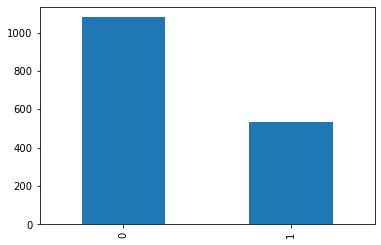

In [11]:
train_data['Resp'].value_counts().sort_index().plot.bar()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [16]:
y_pred = classifier.predict(X_test)

print('confusion matrix\n')
print(pd.crosstab(pd.Series(y_test, name='actual'), pd.Series(y_pred, name='predicted')))

def get_metrix(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

acc, pre, rec, f1 = get_metrix(y_test, y_pred)
print('accuracy: %.3f \nprecision: %.3f \nrecall: %.3f \nf1: %.3f \n' % (acc, pre, rec, f1))

confusion matrix

predicted    0   1
actual            
0          289  40
1           87  68
accuracy: 0.738 
precision: 0.724 
recall: 0.738 
f1: 0.723 

